# Introduction to Deep Learning, Assignment 2, Task 2

# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*

When using the Lab Computers, download the Jupyter Notebook to one of the machines first.

If you want to use Google Colab, you should first copy this notebook and enable GPU runtime in 'Runtime -> Change runtime type -> Hardware acceleration -> GPU **OR** TPU'.


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

2025-11-28 02:52:58.871381: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 02:52:58.900061: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 02:53:03.121656: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


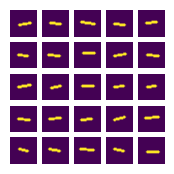

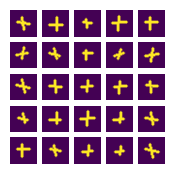

In [2]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [3]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #3137

X_text: "15-68" = y_text: "-53"


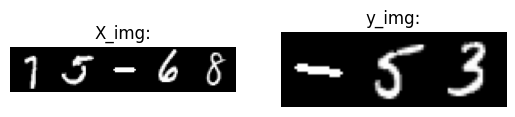

Query #9068

X_text: "45+34" = y_text: "79 "


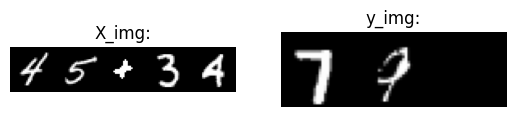

Query #3790

X_text: "18+95" = y_text: "113"


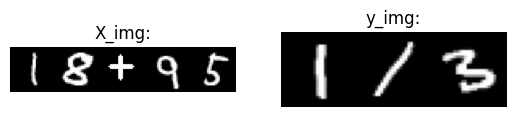

Query #4261

X_text: "21-30" = y_text: "-9 "


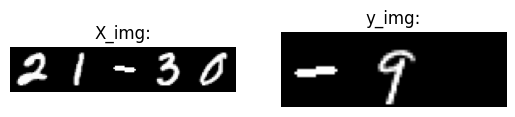

Query #8763

X_text: "43-81" = y_text: "-38"


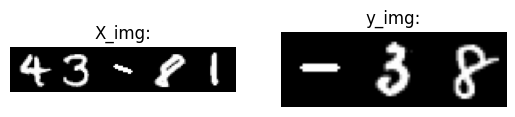

Query #3552

X_text: "17+76" = y_text: "93 "


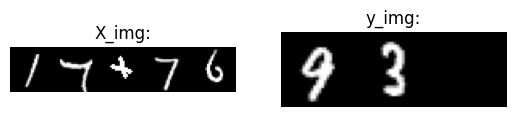

Query #9796

X_text: "48+98" = y_text: "146"


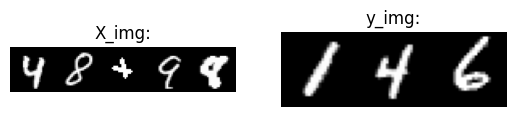

Query #5825

X_text: "29-12" = y_text: "17 "


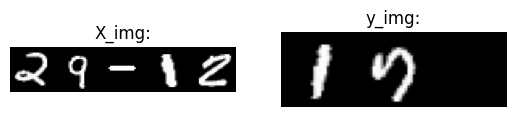

Query #7812

X_text: "39+6 " = y_text: "45 "


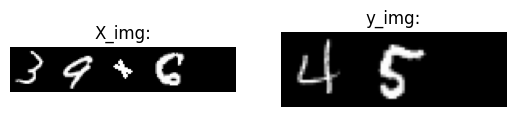

Query #8622

X_text: "43+11" = y_text: "54 "


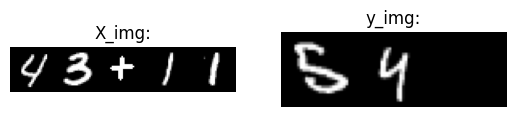

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=2)
    predicted = [''.join([unique_characters[i] for i in j]) for j in pred]

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [6]:
def build_text2text_model():

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    # input_shape=(5, 13)
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

An LSTM input has this shape:
(batch_size, timesteps, features)

timesteps = max_query_length = 5

features = len(unique_characters) = 13

(None, 5, 13)

In [7]:
## Your code (look at the assignment description for your tasks for text-to-text model):
## Your first task is to fit the text2text model using X_text and y_text)

t2t_model = build_text2text_model()

X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, 
                                                    y_text_onehot,
                                                    test_size= 0.5,
                                                    random_state= 42,
                                                    shuffle= True)

hist_t2t_50 = t2t_model.fit(X_train, 
                        y_train, 
                        epochs=20,
                        validation_data=(X_test, y_test))

acc = hist_t2t_50.history.get("accuracy")[-1] 
val_acc = hist_t2t_50.history.get("val_accuracy")[-1]
val_loss = hist_t2t_50.history.get("val_loss")[-1]

print(f"accuracy {acc}")
print(f"validation accuracy {val_acc}")
print(f"validation loss {val_loss}")

test_loss, test_acc = t2t_model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

# 5. Inspect some predictions vs ground truth
#    (convert one-hot output back to strings using decode_labels)
idx = np.random.choice(len(X_test), size=10, replace=False)

y_true_strings = decode_labels(y_test[idx])
y_pred_probs   = t2t_model.predict(X_test[idx])
y_pred_strings = decode_labels(y_pred_probs)

for i in range(len(idx)):
    print(f"Query:      {X_text[idx[i]]}")
    print(f"True ans:   '{y_true_strings[i]}'")
    print(f"Predicted:  '{y_pred_strings[i]}'")
    print('-' * 40)


I0000 00:00:1764294788.881114 1293387 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1185 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-11-28 02:53:10.232656: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3700 - loss: 1.8772 - val_accuracy: 0.4178 - val_loss: 1.6505
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4579 - loss: 1.5003 - val_accuracy: 0.4567 - val_loss: 1.4497
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5167 - loss: 1.3283 - val_accuracy: 0.5320 - val_loss: 1.2695
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5490 - loss: 1.2324 - val_accuracy: 0.5560 - val_loss: 1.2104
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5829 - loss: 1.1433 - val_accuracy: 0.5803 - val_loss: 1.1311
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5979 - loss: 1.0899 - val_accuracy: 0.5723 - val_loss: 1.1924
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6103 - loss: 1.0551 - val_accuracy: 0.6131 - val_loss: 1.0169
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6255 - loss: 1.0065 - val_accuracy: 0.6293 - val_


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [8]:
# Your code
def build_img2text_model():

    # We start by initializing a sequential model
    img2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    # input_shape = (timesteps, features)
    img2text.add(LSTM(256, input_shape=(5, 28*28))) 
    
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    # img2text.add(LSTM(256, return_sequences=True))
    img2text.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))


    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    img2text.summary()

    return img2text



In [9]:
# Your code
def build_img2text_model_conv():

    # We start by initializing a sequential model
    img2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    # input_shape = (timesteps, features)
    # img2text.add(LSTM(256, input_shape=(5, 28*28))) 
    img2text.add(ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        activation='tanh',
        input_shape=(max_query_length, 28, 28, 1),
        return_sequences=False
    ))
    img2text.add(tf.keras.layers.BatchNormalization())

      # Flatten encoder output to pass into dense layers
    img2text.add(Flatten())

    # A Dense layer to compress features into a 256-dimensional vector
    img2text.add(Dense(256, activation='relu'))
    img2text.add(tf.keras.layers.Dropout(0.4))
    
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    # img2text.add(LSTM(256, return_sequences=True))
    img2text.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))


    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    img2text.summary()

    return img2text



In [10]:
print(X_text[0])
print(X_img[0])

0+0  
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [11]:
print(X_text.shape)
print(X_img.shape)

(20000,)
(20000, 5, 28, 28)


In [12]:
print(X_img.shape[0])
print(X_img.shape[1])
print(X_img.shape[2])
print(X_img.shape[3])

20000
5
28
28


In [17]:
# X_img shape: (N, 5, 28, 28)
# Reshape to (N, 5, 28*28) for the LSTM
X_img_flat = X_img.reshape(X_img.shape[0], X_img.shape[1], X_img.shape[2]*X_img.shape[3])
print("X_img_flat shape:", X_img_flat.shape)
X_img_flat_onehot = encode_labels(X_img_flat)


X_img_flat shape: (20000, 5, 784)


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
img2text = build_img2text_model()

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_img_flat_onehot,
    y_text_onehot,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

history_i2t = img2text.fit(
    X_train_i, y_train_i,
    validation_data=(X_test_i, y_test_i),
    epochs=20
)

test_loss_i, test_acc_i = img2text.evaluate(X_test_i, y_test_i, verbose=0)
print(f"Flattened [Image→Text] Test loss: {test_loss_i:.4f}, Test accuracy: {test_acc_i:.4f}")

idx = np.random.choice(len(X_test_i), size=10, replace=False)
y_true_strings = decode_labels(y_test_i[idx])
y_pred_probs   = img2text.predict(X_test_i[idx])
y_pred_strings = decode_labels(y_pred_probs)

for i in range(len(idx)):
    print(f"Query images index: {idx[i]}")
    print(f"True ans:   '{y_true_strings[i]}'")
    print(f"Predicted:  '{y_pred_strings[i]}'")
    print('-' * 40)


/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 256)            │     1,065,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,594,637 (6.08 MB)

 Trainable params: 1,594,637 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3602 - loss: 1.9698 - val_accuracy: 0.3948 - val_loss: 1.8094
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4085 - loss: 1.6983 - val_accuracy: 0.4195 - val_loss: 1.6391
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4360 - loss: 1.5835 - val_accuracy: 0.4348 - val_loss: 1.5940
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4633 - loss: 1.4889 - val_accuracy: 0.4507 - val_loss: 1.5139
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4824 - loss: 1.4141 - val_accuracy: 0.4569 - val_loss: 1.5017
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5024 - loss: 1.3544 - val_accuracy: 0.4685 - val_loss: 1.4805
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5208 - loss: 1.2885 - val_accuracy: 0.4660 - val_loss: 1.5115
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5440 - loss: 1.2286 - val_accuracy: 0.

In [15]:
img2text = build_img2text_model_conv()

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_img,
    y_text_onehot,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

history_i2t = img2text.fit(
    X_train_i, y_train_i,
    validation_data=(X_test_i, y_test_i),
    epochs=20
)

test_loss_i, test_acc_i = img2text.evaluate(X_test_i, y_test_i, verbose=0)
print(f"[Image→Text] Test loss: {test_loss_i:.4f}, Test accuracy: {test_acc_i:.4f}")

# Compare some predictions
idx = np.random.choice(len(X_test_i), size=10, replace=False)
y_true_strings = decode_labels(y_test_i[idx])
y_pred_probs   = img2text.predict(X_test_i[idx])
y_pred_strings = decode_labels(y_pred_probs)

for i in range(len(idx)):
    print(f"Query images index: {idx[i]}")
    print(f"True ans:   '{y_true_strings[i]}'")
    print(f"Predicted:  '{y_pred_strings[i]}'")
    print('-' * 40)


/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 26, 26, 32)     │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,104,973 (23.29 MB)

 Trainable params: 6,104,909 (23.29 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20


E0000 00:00:1764294851.990130 1293387 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/while/body/_52/input/_1118' -> 'StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/while/body/_52/sequential_2_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul', 'StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/while/StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/zeros_switch/_129-0-TransposeNHWCToNCHW-LayoutOptimizer' -> 'StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/while/StatefulPartitionedCall/sequential_2_1/conv_lstm2d_1/zeros_switch/_129'}.


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3249 - loss: 2.1128 - val_accuracy: 0.3576 - val_loss: 2.1433
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.3808 - loss: 1.9217 - val_accuracy: 0.3897 - val_loss: 1.9145
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.3968 - loss: 1.8185 - val_accuracy: 0.3860 - val_loss: 1.8462
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4111 - loss: 1.7392 - val_accuracy: 0.3939 - val_loss: 1.8155
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4275 - loss: 1.6690 - val_accuracy: 0.3970 - val_loss: 1.8239
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4469 - loss: 1.6017 - val_accuracy: 0.3945 - val_loss: 1.7890
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4708 - loss: 1.5280 - val_accuracy: 0.3765 - val_loss: 1.9124
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4949 - loss: 1.4596 - val_accuracy: 0.39

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [23]:
# Your code
def build_text2img_model():

    # We start by initializing a sequential model
    text2img = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2img.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2img.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2img.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    # For each timestep, output 784 pixels
    text2img.add(TimeDistributed(Dense(28*28, activation='sigmoid')))
    
    # Reshape each timestep to an image
    text2img.add(TimeDistributed(Reshape((28, 28))))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2img.compile(loss='binary_crossentropy', optimizer='adam')
    text2img.summary()

    return text2img



/vol/home/s4786793/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_9 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 3, 784)         │       201,488 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 3, 28, 28)      │             0 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,280 (3.83 MB)

 Trainable params: 1,003,280 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3372 - val_loss: 0.2211
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2183 - val_loss: 0.2159
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2149 - val_loss: 0.2146
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2146 - val_loss: 0.2145
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2145 - val_loss: 0.2146
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2145 - val_loss: 0.2147
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2146 - val_loss: 0.2146
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2145 - val_loss: 0.2146
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2146 - val_loss: 0.2147
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2146 - val_loss: 0.2147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


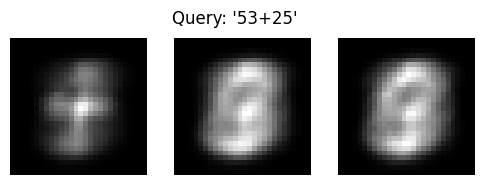

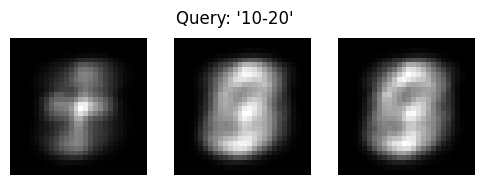

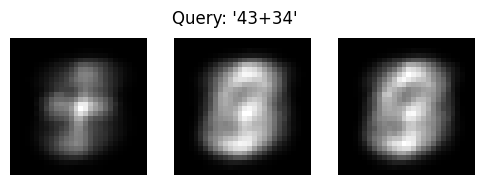

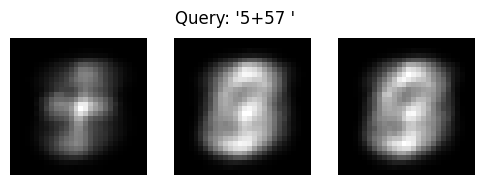

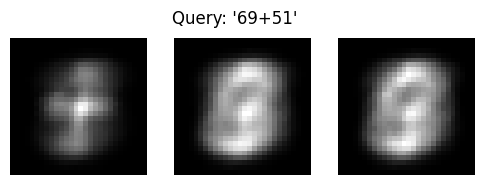

In [29]:
# 1. Track indices
indices = np.arange(len(X_text_onehot))

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

# 2. Split using indices
X_train_ti = X_text_onehot[train_idx]
X_test_ti  = X_text_onehot[test_idx]
y_train_ti = y_img[train_idx]
y_test_ti  = y_img[test_idx]

# 3. Train
text2img = build_text2img_model()
history_t2i = text2img.fit(
    X_train_ti, y_train_ti,
    validation_data=(X_test_ti, y_test_ti),
    epochs=10,
    batch_size=128
)

# 4. Predict first 5 test images
y_pred_img = text2img.predict(X_test_ti[:5])

# 5. Plot
for i in range(5):
    plt.figure(figsize=(6,2))
    for t in range(3):
        plt.subplot(1,3,t+1)
        plt.imshow(y_pred_img[i,t], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Query: '{X_text[test_idx[i]]}'")
    plt.show()


In [34]:
def build_text2img_model_conv():
    model = tf.keras.Sequential()

    # Encoder
    model.add(LSTM(256, input_shape=(max_query_length, len(unique_characters))))

    # Repeat for three digits
    model.add(RepeatVector(max_answer_length))

    # Dense to create feature maps (7x7x64 = 3136)
    model.add(TimeDistributed(Dense(7*7*64, activation='relu')))
    model.add(TimeDistributed(Reshape((7, 7, 64))))

    # Decoder: upsample to 14×14
    model.add(TimeDistributed(Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')))
    model.add(TimeDistributed(tf.keras.layers.BatchNormalization()))

    # Decoder: upsample to 28×28
    model.add(TimeDistributed(Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='sigmoid')))

    model.compile(loss='binary_crossentropy', optimizer='adam')
    model.summary()
    return model


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_12 (RepeatVector) │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 3, 3136)        │       805,952 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 3, 7, 7, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 3, 14, 14, 32)  │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 3, 14, 14, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 3, 28, 28, 1)   │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,101,313 (4.20 MB)

 Trainable params: 1,101,249 (4.20 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.5117 - val_loss: 0.3908
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3322 - val_loss: 0.2938
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2543 - val_loss: 0.2400
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2303 - val_loss: 0.2261
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2237 - val_loss: 0.2224
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2214 - val_loss: 0.2211
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2203 - val_loss: 0.2200
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2197 - val_loss: 0.2200
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2193 - val_loss: 0.2197
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2191 - val_loss: 0.2191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


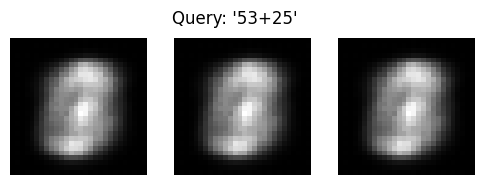

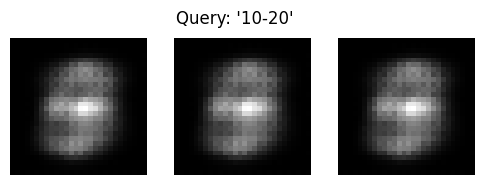

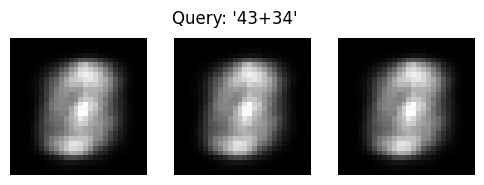

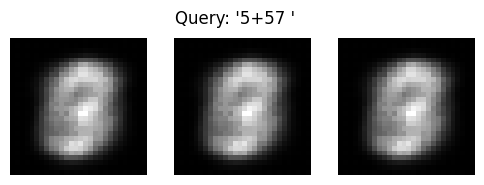

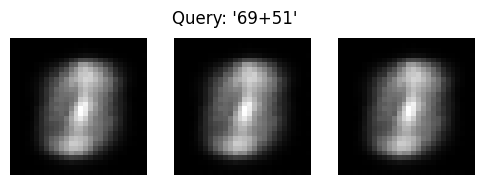

In [35]:
# 1. Track indices
indices = np.arange(len(X_text_onehot))

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

# 2. Split using indices
X_train_ti = X_text_onehot[train_idx]
X_test_ti  = X_text_onehot[test_idx]
y_train_ti = y_img[train_idx]
y_test_ti  = y_img[test_idx]

# 3. Train
text2img = build_text2img_model_conv()
history_t2i = text2img.fit(
    X_train_ti, y_train_ti,
    validation_data=(X_test_ti, y_test_ti),
    epochs=10,
    batch_size=128
)

# 4. Predict first 5 test images
y_pred_img = text2img.predict(X_test_ti[:5])

# 5. Plot
for i in range(5):
    plt.figure(figsize=(6,2))
    for t in range(3):
        plt.subplot(1,3,t+1)
        plt.imshow(y_pred_img[i,t], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Query: '{X_text[test_idx[i]]}'")
    plt.show()
